## Data Processing - FBMN
Authors: Abzer Kelminal (abzer.shah@uni-tuebingen.de) <br>
Edited by:  <br>
Input file format: .csv files or .txt files <br>
Outputs: .csv files  <br>
Dependencies: ggplot2, readxl, dplyr

In [1]:
setwd("C:/Users/Raw_Data_Processing_Dummy_Files")
#C:\Users\Nutzer

In [ ]:
#install packages if not present
install.packages('readxl')
install.packages('dplyr')
install.packages('ggplot2')

In [2]:
library(readxl)
library(dplyr)
library(ggplot2)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



### Creating a function - FrequencyPlot:
The below function takes in the two input data tables, calculates the frequency distribution of the data in the order of 10 and produces a grouped barplot showing the distribution as output.

In [3]:
options(repr.plot.width=5, repr.plot.height=3) #'global' settings for plot size in the output cell

FrequencyPlot <- function(x1,x2){
  
  bins <- c(-1,0,(1 * 10^(seq(0,10,1)))) #creating bins from -1 to 10^10 using sequence function: seq()
  
  scores_x1 <- cut(as.matrix(x1),bins,labels = c('0','1','10','1E2','1E3','1E4','1E5','1E6','1E7','1E8','1E9','1E10')) #cut function store the data into the appropriate bins
  Table_x1<-transform(table(scores_x1)) #transform function convert the tables into column format: easy for visualization
  
  # Repeating the same steps for x2
  scores_x2 <- cut(as.matrix(x2),bins,labels = c('0','1','10','1E2','1E3','1E4','1E5','1E6','1E7','1E8','1E9','1E10'))
  Table_x2<-transform(table(scores_x2))
  
  arg1 <- deparse(substitute(x1))
  arg2 <-deparse(substitute(x2))
  
  data_plot <- as.data.frame(c(Table_x1$Freq,Table_x2$Freq))
  colnames(data_plot) <- "Freq"
  data_plot$Condition <- c(rep(arg1,12),rep(arg2,12))
  data_plot$Range_bins <- rep(Table_x1$scores_x1,2)
  data_plot$Log_Freq <- log(data_plot$Freq+1) #Log scaling the frequency values
  
  ## GGPLOT2
   BarPlot <- ggplot(data_plot, aes(Range_bins, Log_Freq, fill = Condition)) + 
    geom_bar(stat="identity", position = "dodge", width=0.4) + 
    scale_fill_brewer(palette = "Set1") +
    ggtitle(label="Frequency plot") +
    xlab("Range") + ylab("(Log)Frequency") + labs(fill = "Data Type") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +   # setting the angle for the x label
    theme(axis.text.y = element_text(angle = 45, vjust = 0.5, hjust=1)) +   # setting the angle for the y label
    theme(plot.title = element_text(hjust = 0.5)) # centering the plot title
  
  print(BarPlot)
}  

In [4]:
gap_filled <- read.csv("Dummy_Quant_Table.csv")
not_gap_filled <- read.csv("Dummy_NotGapFilled_Quant_Table.csv")
metadata <- read_xlsx('metadata_dummy.xlsx')

print(colnames(gap_filled)) 
print(colnames(not_gap_filled))

#Note down the number of additional columns other than your control and sample in the dataset
Col_range_other <- as.double(1):as.double(readline('Column_maximum_others:'))

In [ ]:
#Check if there are any additional columns present in the data tables and remove them. They might appear as column 'X' containing only NAs at the end of the data table.
# For ex:
# gap_filled <- gap_filled[,-43] 

Raw Data Process - YES or NO:YES
[1] "The Range with a minimum value greater than 0 for GapFilled:1E3"
[1] "The Range with a minimum value greater than 0 for NotGapFilled:1E4"


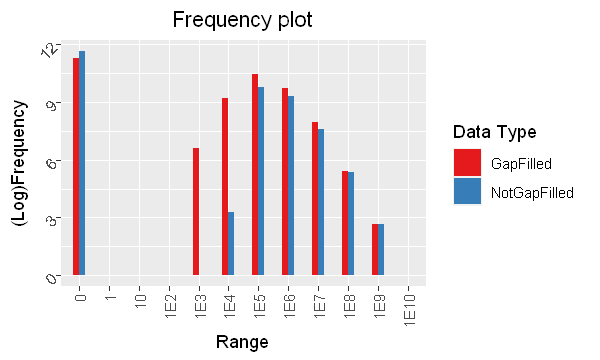

In [5]:
# Run this if you want to replace zeros from the Gap_filled_Quant_Table with the minimum value of Non-gap_filled table
if(readline('Raw Data Process - YES or NO:')=='YES'){
    
    GapFilled <- gap_filled[,-Col_range_other] #taking only the columns with feature intensities
    NotGapFilled <- not_gap_filled[,-Col_range_other]
    
    plot<- FrequencyPlot(GapFilled,NotGapFilled)
    
    Arg1 = plot$data$Condition[1]
    Arg2 = plot$data$Condition[13]
    plotData_New <- subset(plot$data,plot$data$Freq!=0 & plot$data$Range_bins !=0) # accessing the datatable of plot and subsetting with the condition: Eliminating the Range 0 and Ranges with zero frequencies 
    First_val_temp <- aggregate(plotData_New$Freq, by=list(plotData_New$Condition), FUN=first) #getting the first appearing value of this new plot datatable
    First_val <- plotData_New[plotData_New$Freq %in% c(First_val_temp$x[1],First_val_temp$x[2]),] # Subsetting the rows in the plotData_New that has the first appearing values
  
    print(paste0("The Range with a minimum value greater than 0 for ",Arg1,":", First_val$Range_bins[1]))
    print(paste0("The Range with a minimum value greater than 0 for ",Arg2,":", First_val$Range_bins[2]))
    
    RawLOD <- round(min(NotGapFilled[NotGapFilled!=min(NotGapFilled)])) # getting the 2nd minimum value of non-gap filled data. (The first minimum value in the data table is usually zero)
    GapFilled[GapFilled==0 | GapFilled<RawLOD] <- RawLOD # Replacing zeros in the gap-filled file as well as values<RawLOD with RawLOD
    RawLOD_Table <- cbind(gap_filled[,Col_range_other],GapFilled)
    write.csv(RawLOD_Table, file=paste0('Quant_Table_filled_with_MinValue_',RawLOD,'_NotGapFilled','.csv'),row.names =FALSE) 
    input_data <- GapFilled
} else input_data <- gap_filled[,-Col_range_other]
 

### Blank removal:
A **metadata file** needed here to perform the blank removal on individual Ctrl-sample groups within the feature table. <br> 

**For example:** <br>
In the following cell, NewFile contains only the files belonging to samples with the following conditions:
1. that are treated with 20% MeOH
2. strains involving only Ecoli and its control (in other words, the strains that are not Synechococcus) 
3. BG11 control media is excluded as it is used for Synechococcus. 


In [6]:
# Reproducing Daniel's result: (Will change this later)
ordered_data <- input_data[,order(colnames(input_data))] #ordered the input data according to its column names
print(colnames(ordered_data))

Set1 <- ordered_data 

 [1] "Control_BG11_20MeOH_metabolomics.mzML.Peak.area"                        
 [2] "Control_BG11_80MeOH_metabolomics.mzML.Peak.area"                        
 [3] "Control_LB_20MeOH_metabolomics_fixed.mzML.Peak.area"                    
 [4] "Control_LB_80MeOH_metabolomics.mzML.Peak.area"                          
 [5] "Ecoli_delta_20MeOH_metabolomics_1.mzML.Peak.area"                       
 [6] "Ecoli_delta_20MeOH_metabolomics_2.mzML.Peak.area"                       
 [7] "Ecoli_delta_20MeOH_metabolomics_3.mzML.Peak.area"                       
 [8] "Ecoli_delta_80MeOH_metabolomics_2.mzML.Peak.area"                       
 [9] "Ecoli_delta_80MeOH_metabolomics_3.mzML.Peak.area"                       
[10] "Ecoli_WT_20MeOH_metabolomics_1.mzML.Peak.area"                          
[11] "Ecoli_WT_20MeOH_metabolomics_2.mzML.Peak.area"                          
[12] "Ecoli_WT_20MeOH_metabolomics_3.mzML.Peak.area"                          
[13] "Ecoli_WT_20MeOH_metabolomics_3_20220129030420.

In [7]:
# By looking at the column names of input data, choose the desired column range for control and samples.
Ctrl <- as.matrix(ordered_data[,as.double(readline('Column_min_Control:')):as.double(readline('Column_max_Control:'))])
Samples <- as.matrix(ordered_data[,as.double(readline('Column_min_Samples:')):ncol(ordered_data)])

Column_min_Control:1
Column_max_Control:4
Column_min_Samples:5


**Next 2 cells**: Don't run it now. It is for getting selective datasets within the input data using metadata information

In [ ]:
# 'NewFile' gets the file names to be extracted
NewFile <- metadata %>% 
  filter(`ATTRIBUTE_extraction-method` == "20MeOH", `ATTRIBUTE_strain` != 'Synechococcus',`ATTRIBUTE_mutant` != 'BG11')

# 'Set1'  uses the NewFile names and extract those files from the gap-filled data table
Set1 <-c() 
for (i in 1:nrow(NewFile)){
  x<- input_data[,which (colnames(input_data) == NewFile$filename[i])]
  Set1 <- cbind(Set1,x)
}
colnames(Set1) <- NewFile$filename

In [ ]:
ordered_Set1 <- Set1[,order(colnames(Set1))] #ordered the input data according to its column names
print(colnames(ordered_Set1)) #To see all the column names of the ordered data

### Finding the number of potential background or Noise features:

In [ ]:
# By looking at the column names of input data, choose the desired column range for control and samples.
Ctrl <- as.matrix(Set1[,as.double(readline('Column_min_Control:')):as.double(readline('Column_max_Control:'))])
Samples <- as.matrix(Set1[,as.double(readline('Column_min_Samples:')):ncol(Set1)])

Blank Removal Process - YES or NO:YES
Enter Cutoff value between 0.1 & 0.3:0.3
[1] "No.of NA values in  : 0"
[1] "No.of NA values in  : 0"
[1] "No.of NA values in  : 0"
[1] "No.of NA values in  : 0"
[1] "No.of Background or noise features: 3349"
[1] "No.of features after excluding noise: 1698"


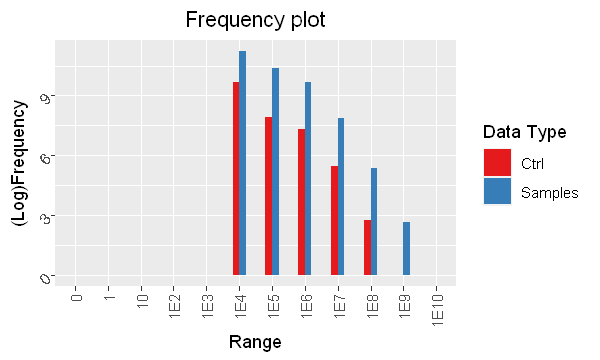

In [10]:
if(readline('Blank Removal Process - YES or NO:')=='YES'){
    Cutoff <- readline('Enter Cutoff value between 0.1 & 0.3:') # (i.e. 10% - 30%). 
    #When cutoff is low, more noise (or background) detected; With higher cutoff, less background detected, thus more features observed
    
    Avg_ctrl <- rowMeans(Ctrl, na.rm= FALSE, dims = 1) # set na.rm = FALSE to check if there are NA values. Because when set as TRUE, NA values are changed to 0
    Avg_samples <- rowMeans(Samples, na.rm= FALSE, dims = 1)
    Ratio_Ctrl_Sample <- (Avg_ctrl+1)/(Avg_samples+1)
    Bg_bin <- ifelse(Ratio_Ctrl_Sample > Cutoff, 1, 0 )  # checks if the Ratio is greater than Cutoff, if so put 1, else 0 in Bg_bin


# to check if there are any NA values present. It is not good to have NA values in the 4 variables as it will affect the final dataset to be created
    temp_NA_Count <-cbind(Avg_ctrl,Avg_samples,Ratio_Ctrl_Sample,Bg_bin)

    for (i in 1:ncol(temp_NA_Count)){
      print(paste('No.of NA values in',colnames(temp_NA_Count[i]),":",sum(is.na(temp_NA_Count[,i])== TRUE)))
    }

    Bg_Features <- sum(Bg_bin ==1,na.rm = TRUE) # Calculates the number of background features present
    No_of_Features <- nrow(Set1) - Bg_Features
    print(paste("No.of Background or noise features:",Bg_Features))
    print(paste("No.of features after excluding noise:",No_of_Features)) 

    input_data1 <- cbind(as.matrix(Set1),Bg_bin)    
    plot_CtrlSample <- FrequencyPlot(Samples,Ctrl)
}

In [11]:
#The frequency plot shows where the features are present in higher number. 
#For ex: if until 1E2 has no or really less features, the goal is to exclude until that range and consider only values from 1E3 range. 
#Thus 1E3 will be taken as Cutoff_LOD (Limit of Detection). This value will eventually become the 'new zero'

#Cutoff_LOD <- as.numeric(readline("Enter your Cutoff LOD here:"))   # Example: 1E2 (means 10^2). Enter the LOD value as seen in the frequency plot

Cutoff_LOD <-ifelse(readline("Raw Data Processing done?")=="YES",RawLOD,as.numeric(readline("Enter your Cutoff LOD here:")))
temp_matrix <- c()
for (i in 1:ncol(Samples)){ # Replacing the Sample intensities with Cutoff_LOD, if they are lower than Cutoff_LOD
    x <- ifelse(Samples[,i] > Cutoff_LOD, Samples[,i],Cutoff_LOD)
    temp_matrix <- cbind(temp_matrix,as.matrix(x))
}
colnames(temp_matrix) <- colnames(Samples)
  
Final_matrix <-c()
for (i in 1:ncol(temp_matrix)){
    x <-ifelse(input_data1[,ncol(input_data1)] ==1, Cutoff_LOD, temp_matrix[,i])
    Final_matrix <-cbind(Final_matrix,x)
}
colnames(Final_matrix) <- colnames(Samples)
write.csv(Final_matrix,file=paste0('Processed_Quant_Table_filled_with_Value_',Cutoff_LOD ,'.csv'),row.names =FALSE)


Raw Data Processing done?YES


In [ ]:
Final <-cbind(gap_filled[,Col_range_other],Ctrl,Final_matrix)
Without_Cutoff<-Final[rowMeans(Final[,-Col_range_other])!= Cutoff_LOD,]  #removing all the rows with only cutoff values

### Normalization:

In [ ]:
if (readline("Normalization: YES or NO:") == 'YES'){  
  sample_sum <- colSums(Without_Cutoff[,-Col_range_other], na.rm= TRUE, dims = 1)
  Normalized_data <- c()
  for (i in 1:ncol(Without_Cutoff[,-Col_range_other])){
    x <- Without_Cutoff[,-Col_range_other][,i] / sample_sum[i]
    Normalized_data <- cbind(Normalized_data, x)
  }

  colnames(Normalized_data) <- names(sample_sum)
  Normalized_data <- cbind(Without_Cutoff[,Col_range_other],Normalized_data)
  
  } else return(Without_Cutoff)
  
print(paste('No.of NA values in Normalized data:',sum(is.na(Normalized_data)== TRUE)))
    